## Organizing the data in a data frame

In [1]:
from round import Round
from flanker_data_handler_script import *
data_path='data.csv'
is_answer_true = []
duration_until_click = []
click_duration = []
users_ids=[]
round_numbers = []
rounds_since_last_mistake=[]
rounds_since_last_correct=[]
with open(data_path,'rb') as reader:
    raw_text=reader.read()
    for row_id,row in enumerate(raw_text.split('\n')):
        time_from_last_mistake = None
        time_from_last_correct = None
        user_data, rounds = handle_single_row(row.strip().split(','))
        for r in rounds:
            if not r.is_correct and time_from_last_mistake is None:
                time_from_last_mistake = 0
            elif time_from_last_mistake is not None:
                time_from_last_mistake +=1
            if r.is_correct and time_from_last_correct is None:
                time_from_last_correct = 0
            elif time_from_last_correct is not None:
                time_from_last_correct +=1
            if r.first_click_duration is not None:
                users_ids.append(row_id)
                click_duration.append(int(r.first_click_duration))
                is_answer_true.append(r.is_correct)
                duration_until_click.append(r.duration_until_click)
                round_numbers.append(int(r.round_number[r.round_number.index(' ')+1:]))
                rounds_since_last_mistake.append(time_from_last_mistake)
                rounds_since_last_correct.append(time_from_last_correct)
            if not r.is_correct:
                time_from_last_mistake = 0
            else:
                time_from_last_correct = 0


In [2]:
len(list(set(users_ids)))

92

In [3]:
import pandas as pd
df = pd.DataFrame()
df['is_answer_true']=is_answer_true
df['click_duration']=click_duration
df['duration_until_click']=duration_until_click
df['user']=users_ids
df['round_num'] = round_numbers
df['rounds_since_last_mistake'] = rounds_since_last_mistake
df['rounds_since_last_correct'] = rounds_since_last_correct

In [4]:
df.head()

,is_answer_true,click_duration,duration_until_click,user,round_num,rounds_since_last_mistake,rounds_since_last_correct
0,False,41,371.0,0,15,0.0,1.0
1,True,43,324.0,0,48,6.0,1.0
2,True,62,287.0,0,58,4.0,1.0
3,True,67,344.0,0,100,11.0,1.0
4,True,93,523.0,2,40,NaN,1.0


Let's look at some specific user and see that we did everything fine (We look at the start of the data for the 4th user):

In [5]:
df[df['user']==4].head()

,is_answer_true,click_duration,duration_until_click,user,round_num,rounds_since_last_mistake,rounds_since_last_correct
5,False,39,452.0,4,0,0.0,NaN
6,True,31,625.0,4,1,1.0,0.0
7,True,50,899.0,4,2,2.0,1.0
8,True,46,749.0,4,3,3.0,1.0
9,True,48,637.0,4,4,4.0,1.0


Let's make a list of the users we want to keep (had 60 rounds and at least 1 mistake)

In [6]:
raw_data=df.groupby(['user']).agg(['sum','count','mean'])
users_who_had_at_least_60_rounds = raw_data['round_num']['count']>60
users_who_made_a_mistake = (raw_data['is_answer_true']['count']>raw_data['is_answer_true']['sum'])

users_who_were_sometimes_wrong = list(raw_data[(users_who_had_at_least_60_rounds) & (users_who_made_a_mistake)].index)

In [7]:
age=[]
gender = []
education = []
is_mobile = []
has_disorder = []
users = []
with open(data_path,'rb') as reader:
    raw_text=reader.read()
    for row_id,row in enumerate(raw_text.split('\n')):
        values = row.split(',')
        if (len(values)==1):
            continue
        is_mobile.append(bool(values[0]))
        gender.append(values[1])
        age.append(int(values[2]))
        has_disorder.append(values[4])
        education.append(values[5])
        users.append(row_id)
user_data = pd.DataFrame(index=users)
user_data['is_mobile'] = is_mobile
user_data['gender'] = gender
user_data['age'] = age
user_data['has_disorder'] = has_disorder
user_data['education'] = education


In [58]:
general_agg = df.groupby('user').agg(['sum','count','mean','std'])
aggregated_df = pd.DataFrame(index=general_agg.index)
aggregated_df['number_of_rounds']=general_agg['round_num']['count']
aggregated_df['average_click_duration']=general_agg['click_duration']['mean']
aggregated_df['std_click_duration']=general_agg['click_duration']['std']
aggregated_df['response time']= general_agg['duration_until_click']['mean']
aggregated_df['rate_of_true']= general_agg['is_answer_true']['mean']


agg_for_true=df[df['is_answer_true']].groupby('user').mean()
aggregated_df['true_answer_average_duration']=aggregated_df.join(agg_for_true,how='left')['click_duration']
aggregated_df['true_answer_average_RT']=aggregated_df.join(agg_for_true,how='left')['duration_until_click']


agg_for_false=df[~df['is_answer_true']].groupby('user').mean()
aggregated_df['false_answer_average_duration']=aggregated_df.join(agg_for_false,how='left')['click_duration']
aggregated_df['false_answer_average_RT']=aggregated_df.join(agg_for_false,how='left')['duration_until_click']

# adding distance 1 to 10 mean duration
for i in range(10):
    agg_for_round=df[df['rounds_since_last_mistake']==float(i)].groupby('user').mean()
    
    aggregated_df[str(i) + '_rounds_since_mistake_average_response_time']=aggregated_df.join(agg_for_round,how='left')['duration_until_click']
    if i>0:
        agg_for_prev_round=df[df['rounds_since_last_mistake']==float(i-1)].groupby('user').mean()
        aggregated_df[str(i) + '_rounds_since_mistake_GAP_RT']= aggregated_df.join(agg_for_round,how='left')['duration_until_click'] - aggregated_df.join(agg_for_prev_round,how='left')['duration_until_click']
    aggregated_df[str(i) + '_rounds_since_mistake_average_duration']=aggregated_df.join(agg_for_round,how='left')['click_duration']
    aggregated_df[str(i) + '_rounds_since_mistake_average_is_correct']=aggregated_df.join(agg_for_round,how='left')['is_answer_true']
i=1
agg_for_round=df[df['rounds_since_last_correct']==float(i)].groupby('user').mean()
aggregated_df[str(i) + '_rounds_since_correct_average_response_time']=aggregated_df.join(agg_for_round,how='left')['duration_until_click']
aggregated_df[str(i) + '_rounds_since_correct_average_duration']=aggregated_df.join(agg_for_round,how='left')['click_duration']
aggregated_df[str(i) + '_rounds_since_correct_average_is_correct']=aggregated_df.join(agg_for_round,how='left')['is_answer_true']

Let's filter the bad users out

In [59]:
final_table = aggregated_df.join(user_data,how='left')[aggregated_df.index.isin(users_who_were_sometimes_wrong)]

Let's see what we made, and also let's save it as 'table.csv'

In [61]:
final_table = final_table.sort_values('average_click_duration')
final_table.to_csv('table.csv')
final_table.head()

,number_of_rounds,average_click_duration,std_click_duration,response time,rate_of_true,true_answer_average_duration,true_answer_average_RT,false_answer_average_duration,false_answer_average_RT,0_rounds_since_mistake_average_response_time,...,9_rounds_since_mistake_average_duration,9_rounds_since_mistake_average_is_correct,1_rounds_since_correct_average_response_time,1_rounds_since_correct_average_duration,1_rounds_since_correct_average_is_correct,is_mobile,gender,age,has_disorder,education
user,,,,,,,,,,,,,,,,,,,,,
132,119,45.638655,12.915456,570.193277,0.991597,45.677966,569.601695,41.00,640.0,640.0,...,41.00,1.0,570.324786,45.786325,0.991453,True,male,23,TRUE,HighSchool
48,119,50.184874,22.237534,674.798319,0.966387,50.286957,684.669565,47.25,391.0,78.0,...,58.25,1.0,676.684211,50.131579,0.973684,True,female,39,FALSE,BA
112,67,56.149254,9.550906,582.313433,0.985075,56.409091,582.151515,39.00,593.0,593.0,...,52.00,1.0,582.313433,56.149254,0.985075,True,male,62,FALSE,MA
140,119,56.294118,15.223395,463.033613,0.991597,56.008475,464.788136,90.00,256.0,256.0,...,62.00,1.0,468.324786,55.760684,1.000000,True,male,33,FALSE,BA
59,79,60.734177,13.750253,619.784810,0.974684,60.506494,624.038961,69.50,456.0,NaN,...,49.00,1.0,616.025974,60.818182,0.974026,True,female,38,FALSE,BA


'table.csv' file in this directory 

## Making some graphs

In [11]:
#mandatory imports
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Let's make a function that displays one statistic vs all other statistics, we will do it in many plots, but that's because Homely aliens don't know how to plot nicely

In [12]:
def plot_1_vs_all(column_to_keep):
    columns_with_average_in_name = [column for column in final_table.columns if 'average' in column and 'duration' in column]
    temp=final_table[columns_with_average_in_name]
    temp.index=range(len(temp.index))
    for c in columns_with_average_in_name:
        if c==column_to_keep:
            continue
        temp2=temp[[c,column_to_keep]]
        temp2.plot()

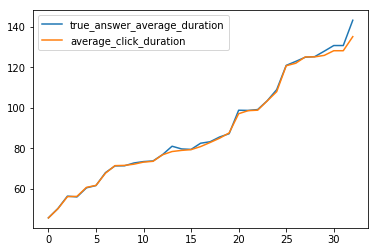

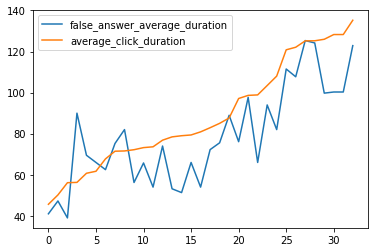

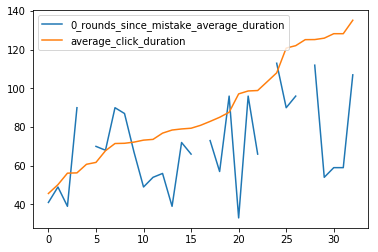

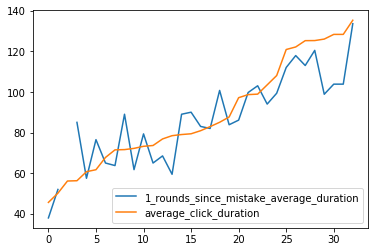

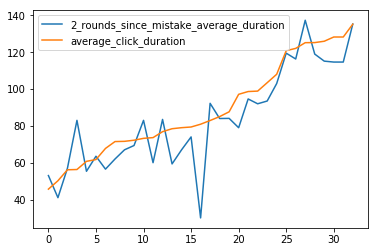

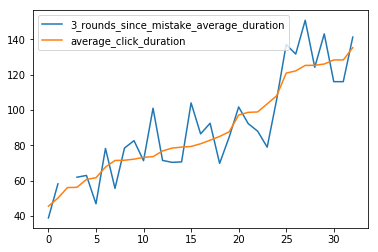

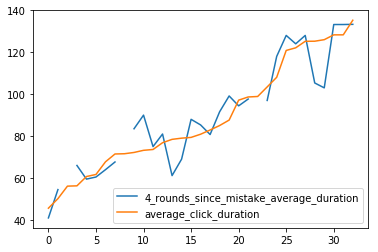

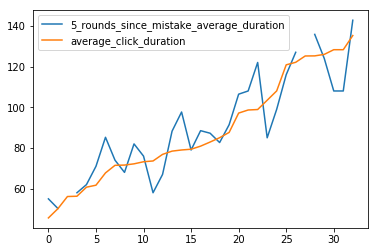

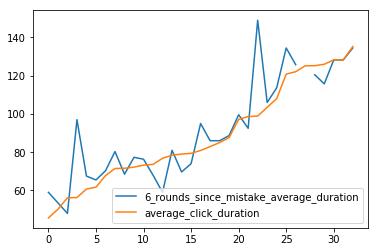

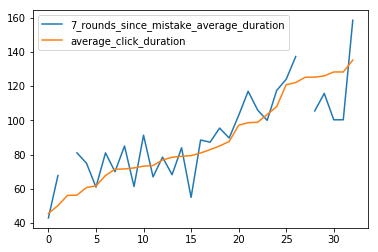

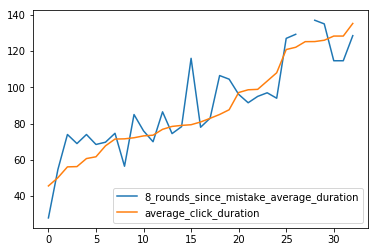

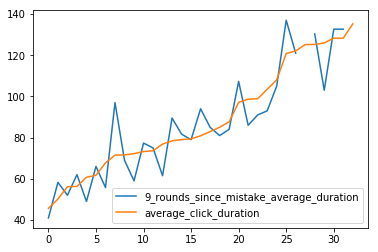

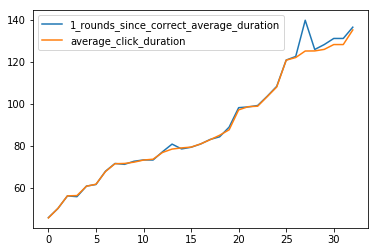

In [13]:
#Average vs all
plot_1_vs_all('average_click_duration')

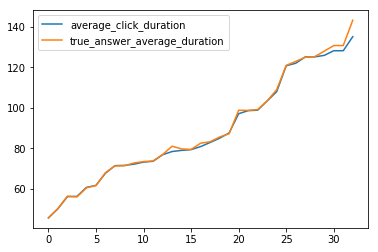

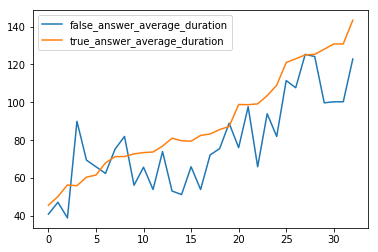

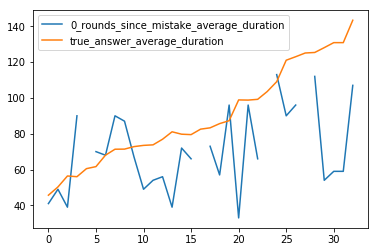

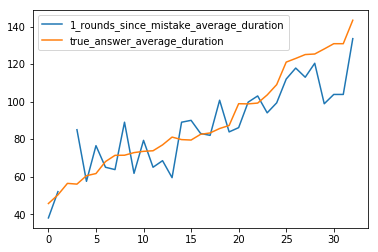

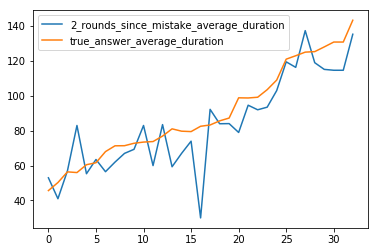

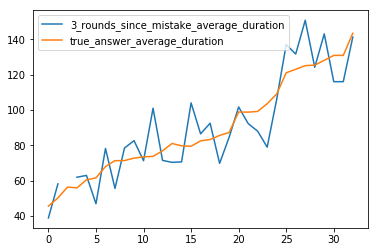

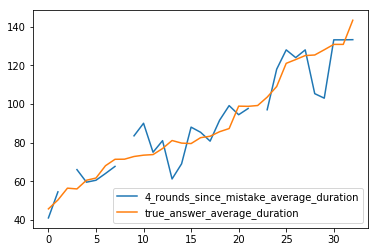

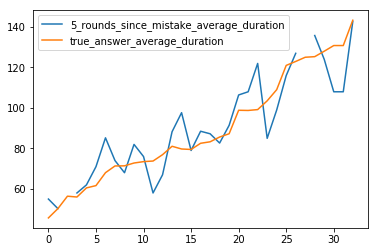

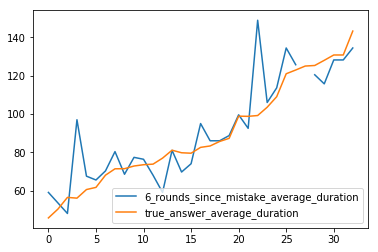

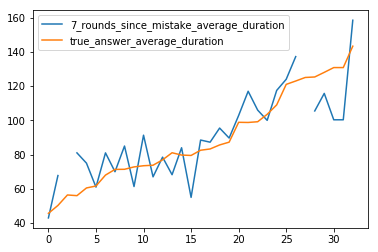

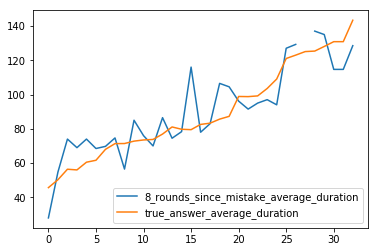

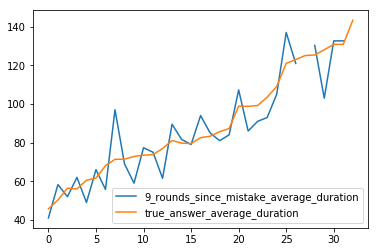

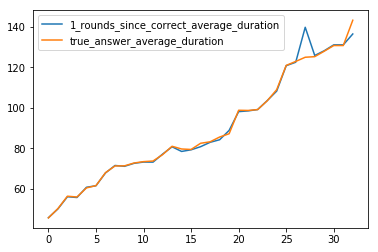

In [14]:
#True vs all
plot_1_vs_all('true_answer_average_duration')

In [15]:
from scipy import stats
stats.ttest_rel(final_table['rate_of_true'],final_table['1_rounds_since_mistake_average_is_correct'],nan_policy ='omit')

Ttest_relResult(statistic=2.697578704280374, pvalue=0.011195935035726632)

In [16]:
from scipy import stats
final_table['0_rounds_since_mistake_average_duration'].corr(final_table['1_rounds_since_mistake_average_is_correct'])

-0.1744836647630221

In [17]:
 from scipy import stats
stats.spearmanr(final_table['0_rounds_since_mistake_average_duration'],final_table['1_rounds_since_mistake_average_is_correct'])

SpearmanrResult(correlation=nan, pvalue=nan)

In [18]:
final_table

,number_of_rounds,average_click_duration,std_click_duration,response time,rate_of_true,true_answer_average_duration,true_answer_average_RT,false_answer_average_duration,false_answer_average_RT,0_rounds_since_mistake_average_response_time,...,9_rounds_since_mistake_average_duration,9_rounds_since_mistake_average_is_correct,1_rounds_since_correct_average_response_time,1_rounds_since_correct_average_duration,1_rounds_since_correct_average_is_correct,is_mobile,gender,age,has_disorder,education
user,,,,,,,,,,,,,,,,,,,,,
132,119,45.638655,12.915456,570.193277,0.991597,45.677966,569.601695,41.000000,640.000000,640.0,...,41.000000,1.000000,570.324786,45.786325,0.991453,True,male,23,TRUE,HighSchool
48,119,50.184874,22.237534,674.798319,0.966387,50.286957,684.669565,47.250000,391.000000,78.0,...,58.250000,1.000000,676.684211,50.131579,0.973684,True,female,39,FALSE,BA
112,67,56.149254,9.550906,582.313433,0.985075,56.409091,582.151515,39.000000,593.000000,593.0,...,52.000000,1.000000,582.313433,56.149254,0.985075,True,male,62,FALSE,MA
140,119,56.294118,15.223395,463.033613,0.991597,56.008475,464.788136,90.000000,256.000000,256.0,...,62.000000,1.000000,468.324786,55.760684,1.000000,True,male,33,FALSE,BA
59,79,60.734177,13.750253,619.784810,0.974684,60.506494,624.038961,69.500000,456.000000,NaN,...,49.000000,1.000000,616.025974,60.818182,0.974026,True,female,38,FALSE,BA
131,119,61.714286,14.560303,546.184874,0.983193,61.641026,543.264957,66.000000,717.000000,565.0,...,66.000000,1.000000,549.672414,61.568966,0.982759,True,male,23,TRUE,HighSchool
128,119,67.747899,16.092012,510.294118,0.949580,68.026549,514.451327,62.500000,432.000000,741.0,...,55.750000,1.000000,508.330357,67.892857,0.964286,True,female,28,TRUE,HighSchool
133,119,71.478992,22.008800,583.512605,0.966387,71.347826,593.139130,75.250000,306.750000,74.0,...,97.000000,1.000000,592.157895,71.587719,0.982456,True,female,22,TRUE,HighSchool
72,110,71.600000,14.225704,619.063636,0.981818,71.407407,621.398148,82.000000,493.000000,625.0,...,69.000000,1.000000,622.186916,71.177570,0.981308,True,female,48,FALSE,BA


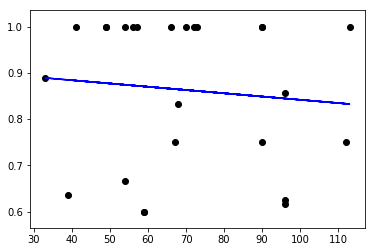

In [50]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
final_table_no_nans=final_table.dropna(axis=0)
x=final_table_no_nans[['0_rounds_since_mistake_average_duration']]
y=final_table_no_nans['1_rounds_since_mistake_average_is_correct']
reg = LinearRegression().fit(x, y)
plt.scatter(x,y,color='black')
plt.plot(x,reg.predict(x),color='blue')
#plt.xlabel('click duration at mistake')
#plt.ylabel('% correct after mistake')

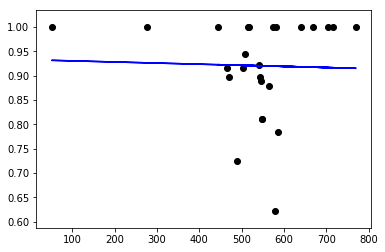

In [53]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
final_table_no_nans=final_table.dropna(axis=0)
x=final_table_no_nans[['1_rounds_since_mistake_average_response_time']]
a=final_table_no_nans['1_rounds_since_mistake_average_is_correct']
b=final_table_no_nans['2_rounds_since_mistake_average_is_correct']
c=final_table_no_nans['3_rounds_since_mistake_average_is_correct']
y=(a+b+c)/3.0
reg = LinearRegression().fit(x, y)
plt.scatter(x,y,color='black')
plt.plot(x,reg.predict(x),color='blue')

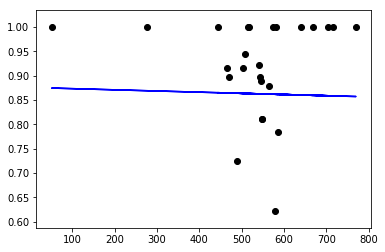

In [55]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
final_table_no_nans=final_table.dropna(axis=0)
x=final_table_no_nans[['1_rounds_since_mistake_average_response_time']]
a=final_table_no_nans['1_rounds_since_mistake_average_is_correct']
reg = LinearRegression().fit(x, a)
plt.scatter(x,y,color='black')
plt.plot(x,reg.predict(x),color='blue')

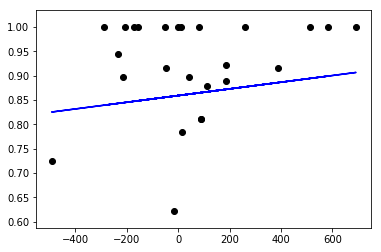

In [62]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
final_table_no_nans=final_table.dropna(axis=0)
x=final_table_no_nans[['1_rounds_since_mistake_GAP_RT']]
a=final_table_no_nans[['1_rounds_since_mistake_average_is_correct']]
reg = LinearRegression().fit(x, a)
plt.scatter(x,y,color='black')
plt.plot(x,reg.predict(x),color='blue')

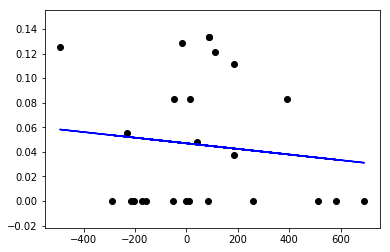

In [64]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
final_table_no_nans=final_table.dropna(axis=0)
x=final_table_no_nans[['1_rounds_since_mistake_GAP_RT']]
a=final_table_no_nans['1_rounds_since_mistake_average_is_correct']
y=(1.0-a)/3.0
reg = LinearRegression().fit(x, y)
plt.scatter(x,y,color='black')
plt.plot(x,reg.predict(x),color='blue')